<a href="https://colab.research.google.com/github/yibowang15/Capstone/blob/VGG16-Initialization/Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Unzip Color Data and Save to local**
- Downloaded from https://www.kaggle.com/c/dogs-vs-cats/overview)

In [ ]:
import shutil
import os
from zipfile import ZipFile

# 定义源文件路径
zip_file_path = '/content/drive/MyDrive/CapstoneProject/data/train.zip'

# 定义解压目标路径
destination_dir = '/content'

# 打开并解压文件
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("解压完成！")


解压完成！


**Plot Color Dog and Cat Photos**

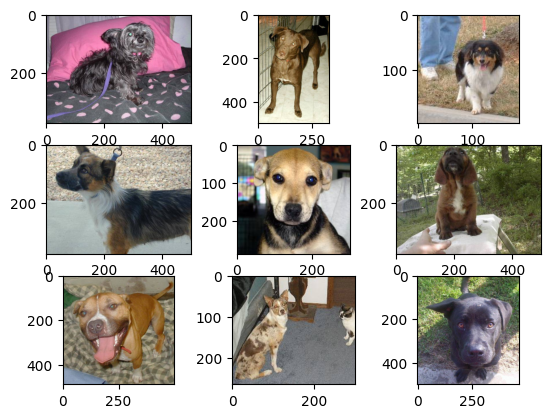

In [ ]:
# Plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# Define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

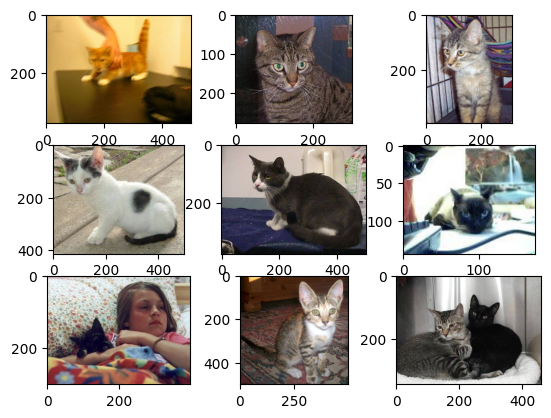

In [ ]:
# Plot cat photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# Define location of dataset
folder = 'train/'
# Plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

**Pre-Process Photo Sizes**
- Adapt to VGG16, image size (224, 224, 3)

In [ ]:
# Load dogs vs cats dataset, reshape and save to a new file
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# Define location of dataset
folder = 'train/'
photos, labels = list(), list()
# Enumerate files in the directory
for file in listdir(folder):
	# Determine class
	output = 0.0
	if file.startswith('dog'):
		output = 1.0
	# Load image
	photo = load_img(folder + file, target_size=(224, 224))
	# convert to numpy array
	photo = img_to_array(photo)
	# store
	photos.append(photo)
	labels.append(output)
# Convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# Save the reshaped photos
save('dogs_vs_cats_photos.npy', photos)
save('dogs_vs_cats_labels.npy', labels)

(25000, 224, 224, 3) (25000,)


**Load and Confirm the Shape**

In [ ]:
# load and confirm the shape
from numpy import load
photos = load('dogs_vs_cats_photos.npy')
labels = load('dogs_vs_cats_labels.npy')
print(photos.shape, labels.shape)

(25000, 224, 224, 3) (25000,)


**Create Directories and Subdirectories**
- Training Validation Testing(8:1:1)
- Provide the model with labels for supervised learning
- Set seed to make sure the result is replicable

In [ ]:
from os import makedirs, listdir
from shutil import copyfile
from random import seed, random

# Creat main directories and the subdirectoires
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'val/', 'test/']  # Create 3 subdirs for train, validation, and test
for subdir in subdirs:
    # create dog and cat lable dir for each subdir
    labeldirs = ['dogs/', 'cats/']
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        makedirs(newdir, exist_ok=True)

# Set random seed to make sure the result is replicable
seed(1)

# Set ratio, training : validation : testing = 8: 1: 1
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Ensure the sum of the ratio is 1
assert train_ratio + val_ratio + test_ratio == 1.0

# Split data into directoires
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + file

    # choose a random dir
    rand_val = random()
    if rand_val < train_ratio:
        dst_dir = 'train/'
    elif rand_val < train_ratio + val_ratio:
        dst_dir = 'val/'
    else:
        dst_dir = 'test/'

    # Put dog or cat data into corresponding label dir
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/' + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/' + file
        copyfile(src, dst)

**Develop a Baseline VGG16 Model**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = VGG16(weights='imagenet', include_top = False, input_shape= (224, 224, 3))

# DIFFERENCE BETWEEN SCENARIO 1 AND SCENARIO 2
#  Freeze all ConvNetlayers
for layer in base_model.layers:
  	  layer.trainable = False
# Unfreeze the layers we want
for layer in base_model.layers[-6:]:
      layer.trainable = True

# Add Flatten Layer
x = Flatten(name = 'Flatten')(base_model.output)  # Flatten

# Add two fully connected layers (4096 hidden units) and their corresponding Dropout Layers
x = Dense(4096, activation='relu', name = 'FC1')(x)
x = Dropout(0.5, name = 'Dropout1')(x)  # Dropout ratio set to 0.5
x = Dense(4096, activation='relu', name = 'FC2')(x)
x = Dropout(0.5, name = 'Dropout2')(x)

# Add binary classification dense layer(Using Sigmoid)
x = Dense(1, activation='sigmoid', name = 'Output_Layer_Classification')(x)

# Add binary classification dense layer(Using Softmax)
# x = Dense(2, activation='softmax', name='Classification')(x)

# Create new model
final_model = Model(inputs=base_model.input, outputs=x)

# Check: check the details of the final model
final_model.summary()

# compile model
opt = SGD(learning_rate=0.0001, momentum=0.9)
final_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# save it as .keras
final_model.save('final_model.keras')

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 134,004,481 (511.19 MB)

 Non-trainable params: 260,160 (1016.25 KB)

**Create Image Generators for Training and Validation Data**
- Batch size 256

In [ ]:
# create generator
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# create generator for training dataset
train_generator = train_datagen.flow_from_directory(
    directory='dataset_dogs_vs_cats/train/',
    target_size=(224, 224),
    batch_size=256,
    class_mode='binary'
)

# create generator for validation set
validation_generator = test_datagen.flow_from_directory(
    directory='dataset_dogs_vs_cats/test/',
    target_size=(224, 224),
    batch_size=256,
    class_mode='binary'
)

**Start Training and Plot**
- Set checkpoint (save as "best_baseline_model.keras")
- Set Early Stopping
- Set Reduce Learning Rate

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

# load the saved model
loaded_model = load_model('final_model.keras')

# # set the check point
# checkpoint = ModelCheckpoint(
#     filepath='best_baseline_model_s2.keras',
#     monitor='val_accuracy',
#     verbose=1,
#     save_best_only=True,
#     mode='max'
# )

# set the check point
checkpoint = ModelCheckpoint(
    filepath='best_baseline_model_s1.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# set early stop
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# reduce the learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # 监控验证准确率
    factor=0.1,  # 当条件满足时将学习率乘以0.1（即减少到原来的1/10）
    patience=4,  # 当验证准确率在3个epoch内不改善时减少学习率
    min_lr=1e-6,  # 最小学习率的下限，确保学习率不会降到0
    verbose=1  # 输出信息，方便观察
)

# train the model
history = loaded_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

# get learning rate for each epoch
lrs = [float(loaded_model.optimizer.learning_rate.numpy()) for epoch in range(len(history.history['accuracy']))]

# get epoch accuracy for each training data and validation data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(len(acc))

# plot the pic
plt.figure(figsize=(10, 5))

# graph the fitting plot
plt.plot(epochs_range, acc, label='Training', color='black')  # black line
plt.plot(epochs_range, val_acc, label='Validation', color='black', linestyle='dashed')  # dashline

# keep left y axis to show the accuracy
plt.title('(a)', loc='left', fontsize=12)  # title
plt.xlabel('Epoch', fontsize=12)  # x
plt.ylabel('Accuracy', fontsize=12)  # Y

# set left Y
plt.ylim(0.7, 1.0)  # set range from 0.7 to 1.0

# set the Yticks
plt.yticks(np.arange(0.7, 1.01, 0.05))  # 0.05


plt.legend(['Training', 'Validation'], loc='best', fontsize=10)

# display the graph
plt.show()

# load the best model
best_model = load_model('best_baseline_model_s1.keras')

# evaluate the best model on traing data
train_loss, train_accuracy = best_model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
print(f"Best Model Training Accuracy: {train_accuracy:.4f}")

# evaluate the model on the validation data
val_loss, val_accuracy = best_model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Best Model Validation Accuracy: {val_accuracy:.4f}")


**Test Model**

In [ ]:

from tensorflow.keras.models import load_model

# lode the trained model
best_model = load_model('best_baseline_model_s1.keras')

# evaluate the model performance on the test dataset
test_generator = test_datagen.flow_from_directory(
    directory='dataset_dogs_vs_cats/test/',
    target_size=(224, 224),
    batch_size=256,
    class_mode='binary',
    shuffle=False
)

# model evaluation
test_loss, test_accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# prediction
predictions = best_model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)  # change to the 1 and 0

# compare the label
true_labels = test_generator.classes
accuracy = (predicted_classes.flatten() == true_labels).mean()

print(f"Calculated Test Accuracy: {accuracy:.4f}")

Found 2525 images belonging to 2 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 423ms/step - accuracy: 0.9677 - loss: 0.0859
Test Accuracy: 0.9644
Test Loss: 0.0888
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 452ms/step
Calculated Test Accuracy: 0.9624


**Save Best Performance Model to Drive**

In [ ]:
import shutil


source_path = '/content/best_baseline_model_s1.keras'

# name saved model
destination_path = '/content/drive/MyDrive/CapstoneProject/models/best_baseline_model_s1.keras'

# move the file and rename it
shutil.move(source_path, destination_path)

print("File hase been renamed and moved to the designated location")